# Analyse exploratoire des données NBA (EDA)

## 1. Chargement des données

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

gamelog = pd.read_parquet("../data/raw/player_gamelog_2023-24.parquet")
phys = pd.read_parquet("../data/raw/player_phys_2023-24.parquet")

df = gamelog.groupby("PLAYER_ID").agg(
    pts_mean=("PTS", "mean"),
    reb_mean=("REB", "mean"),
    ast_mean=("AST", "mean"),
    pm_mean=("PLUS_MINUS", "mean"),
    gp=("GAME_ID", "nunique")
).reset_index()

df = df.merge(phys[["PLAYER_ID", "height_cm", "weight_kg", "bmi", "AGE"]], on="PLAYER_ID", how="left")
df["avail"] = df["gp"] / 82
df.shape

(572, 11)

## 2. Statistiques descriptives

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PLAYER_ID,572.0,1.378544e+06,546379.645029,2544.000000,1.627848e+06,1.629724e+06,1.630702e+06,1.642013e+06
pts_mean,572.0,8.422111e+00,6.790235,0.000000,3.396154e+00,6.422532e+00,1.166412e+01,3.469231e+01
reb_mean,572.0,3.374584e+00,2.427009,0.000000,1.589367e+00,2.977602e+00,4.394159e+00,1.365854e+01
ast_mean,572.0,2.001271e+00,1.875682,0.000000,7.142857e-01,1.307099e+00,2.743038e+00,1.089855e+01
pm_mean,572.0,-4.342014e-01,3.242988,-13.000000,-2.371904e+00,-3.807932e-01,1.485759e+00,8.632911e+00
gp,572.0,4.615559e+01,25.536868,1.000000,2.200000e+01,5.100000e+01,6.900000e+01,8.400000e+01
height_cm,522.0,1.994095e+02,7.948864,172.720000,1.930400e+02,1.981200e+02,2.057400e+02,2.235200e+02
weight_kg,522.0,9.772982e+01,10.792467,72.562358,9.070295e+01,9.750567e+01,1.043084e+02,1.315193e+02
bmi,522.0,2.454215e+01,1.898348,18.672089,2.321322e+01,2.450547e+01,2.571374e+01,3.281354e+01
AGE,522.0,2.615709e+01,4.316001,19.000000,2.300000e+01,2.500000e+01,2.875000e+01,3.900000e+01


## 3. Valeurs manquantes

In [10]:
df.isna().mean().sort_values(ascending=False) * 100

height_cm    8.741259
weight_kg    8.741259
bmi          8.741259
AGE          8.741259
PLAYER_ID    0.000000
pts_mean     0.000000
reb_mean     0.000000
ast_mean     0.000000
pm_mean      0.000000
gp           0.000000
avail        0.000000
dtype: float64

## 4. Distributions des variables

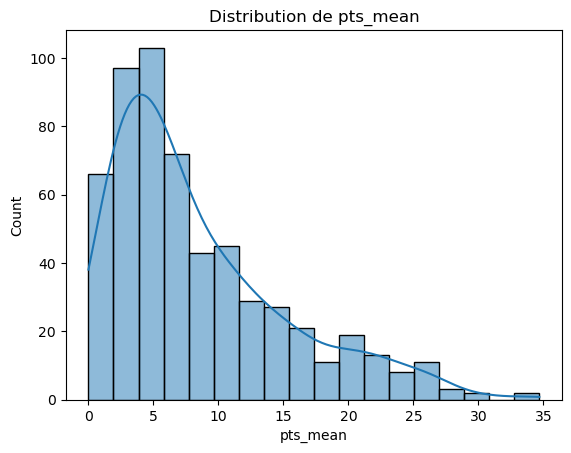

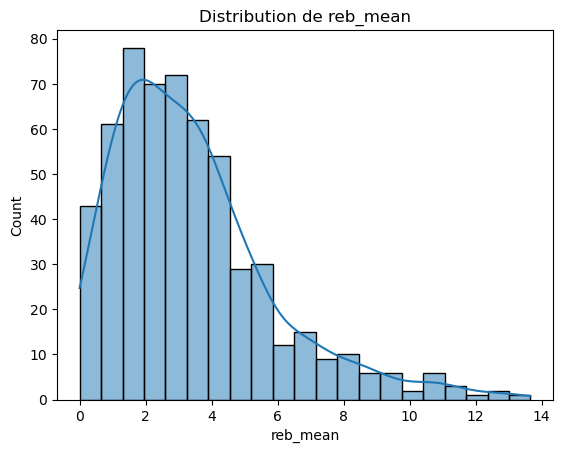

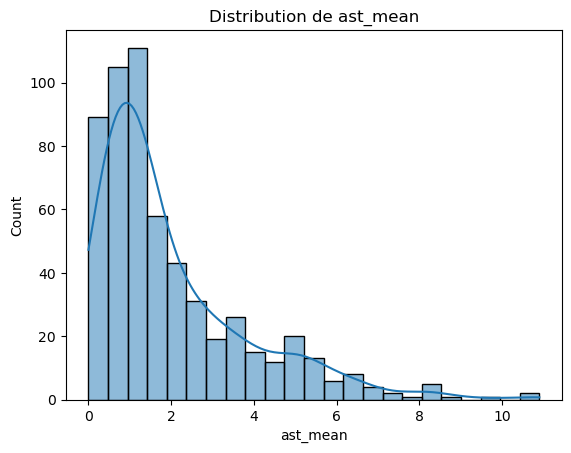

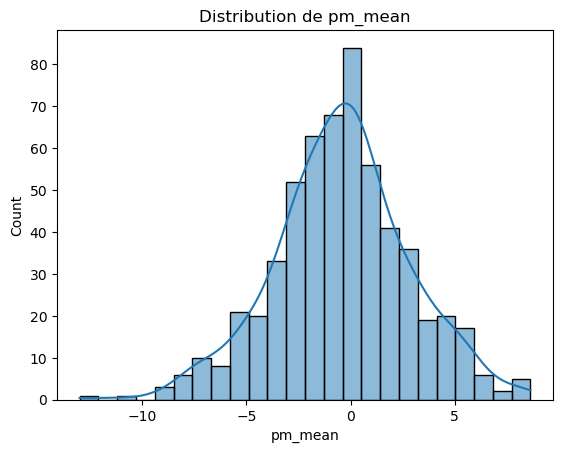

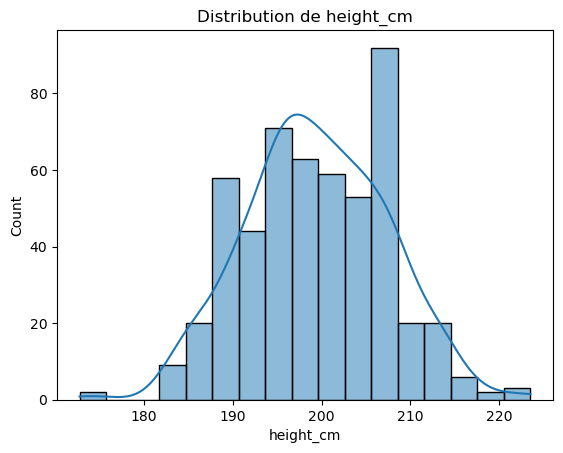

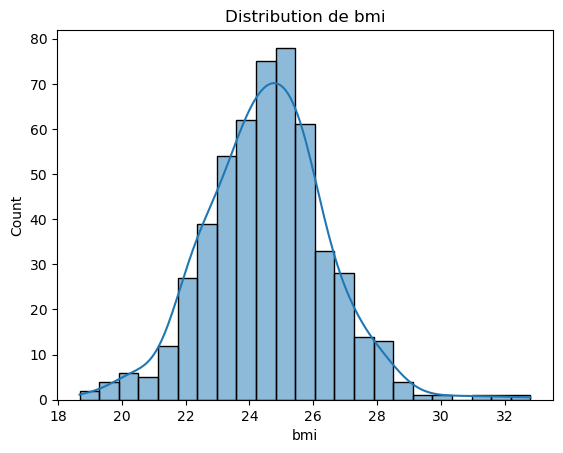

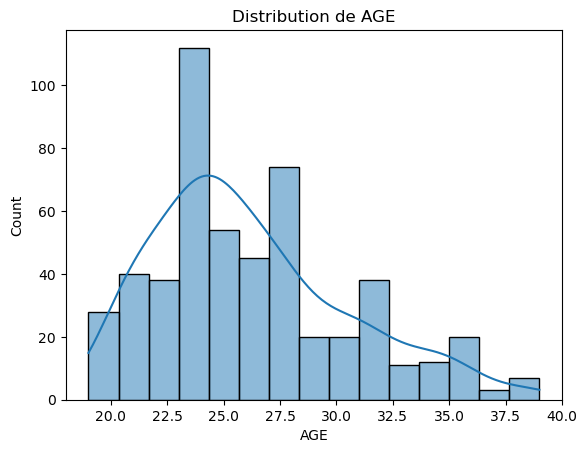

In [11]:
for col in ["pts_mean", "reb_mean", "ast_mean", "pm_mean", "height_cm", "bmi", "AGE"]:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.show()

## 5. Corrélations

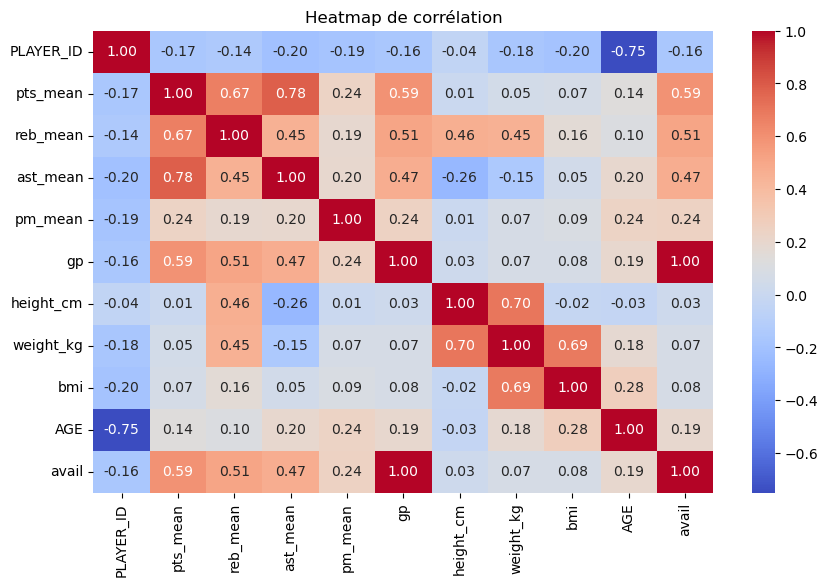

In [12]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de corrélation")
plt.show()

## 6. Détection d'outliers

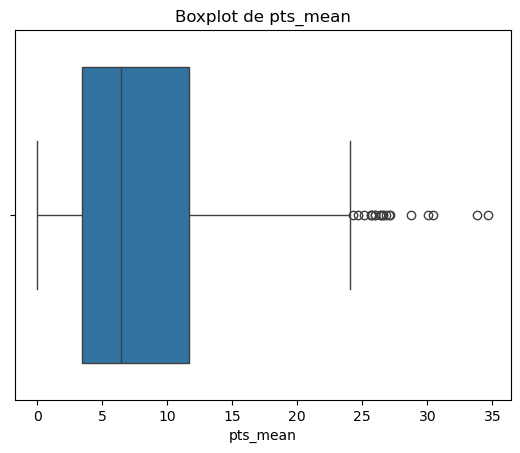

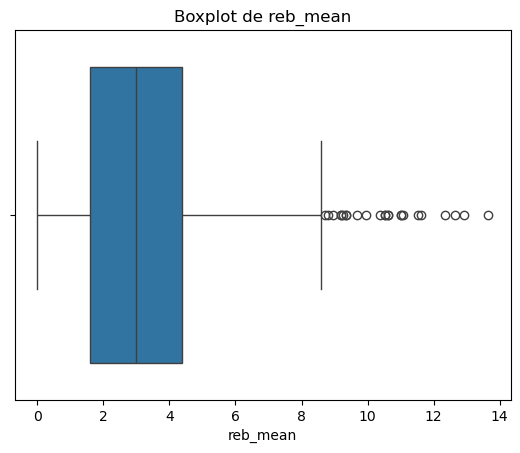

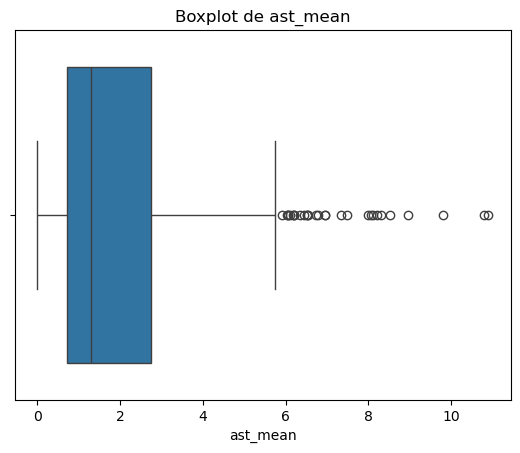

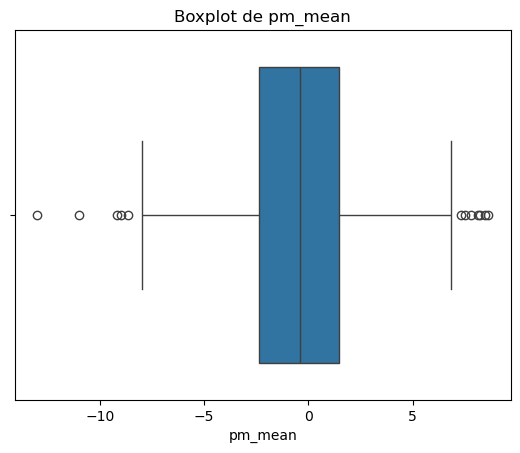

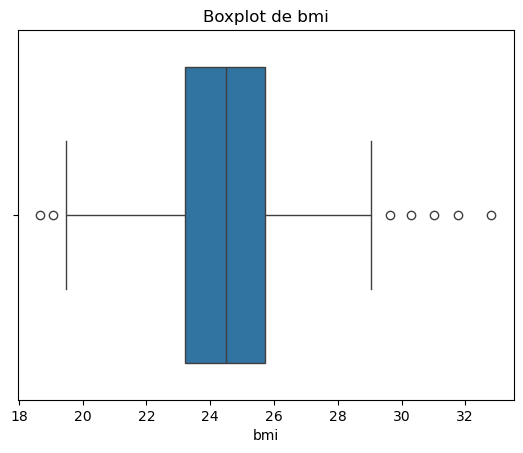

In [32]:
metrics = ["pts_mean", "reb_mean", "ast_mean", "pm_mean", "bmi"]
for col in metrics:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [33]:
outliers = {}
for col in metrics:
    Q1, Q3 = np.percentile(df[col].dropna(), [25, 75])
    IQR = Q3 - Q1
    mask = (df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)
    n_out = mask.sum()
    print(f"{col}: {n_out} outliers")
    outliers[col] = df.loc[mask, ['PLAYER_ID', col]]


pts_mean: 20 outliers
reb_mean: 24 outliers
ast_mean: 29 outliers
pm_mean: 12 outliers
bmi: 7 outliers


## 7. Comparaisons croisées

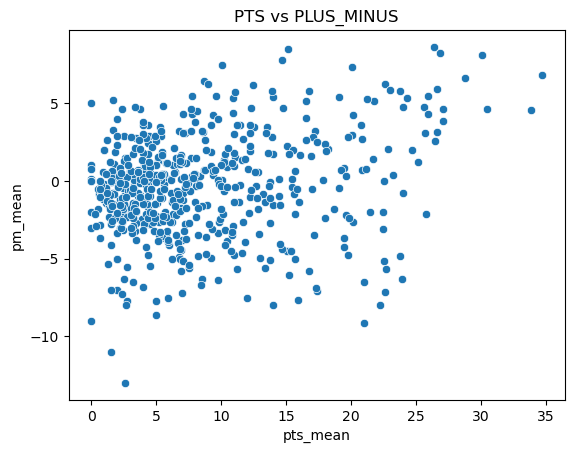

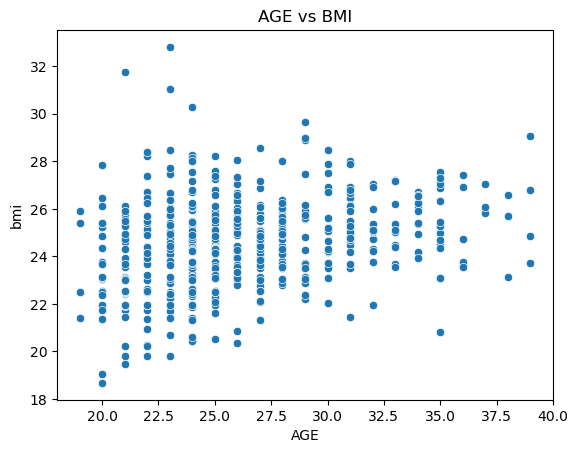

In [14]:
sns.scatterplot(data=df, x="pts_mean", y="pm_mean")
plt.title("PTS vs PLUS_MINUS")
plt.show()

sns.scatterplot(data=df, x="AGE", y="bmi")
plt.title("AGE vs BMI")
plt.show()

----

In [19]:
# Afficher toutes les colonnes disponibles dans le fichier gamelog
import duckdb

con = duckdb.connect()
# Liste complète des colonnes dans le fichier brut
cols_info = con.execute("DESCRIBE SELECT * FROM '../data/raw/player_gamelog_2023-24.parquet'").df()
print(f"Nombre total de colonnes dans gamelog: {len(cols_info)}")
cols_info

Nombre total de colonnes dans gamelog: 32


,column_name,column_type,null,key,default,extra
0,SEASON_ID,VARCHAR,YES,None,None,None
1,PLAYER_ID,BIGINT,YES,None,None,None
2,PLAYER_NAME,VARCHAR,YES,None,None,None
3,TEAM_ID,BIGINT,YES,None,None,None
4,TEAM_ABBREVIATION,VARCHAR,YES,None,None,None
5,TEAM_NAME,VARCHAR,YES,None,None,None
6,GAME_ID,VARCHAR,YES,None,None,None
7,GAME_DATE,VARCHAR,YES,None,None,None
8,MATCHUP,VARCHAR,YES,None,None,None
9,WL,VARCHAR,YES,None,None,None


In [20]:
# Identifier les colonnes les plus corrélées avec la performance
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
import pandas as pd

# Extraire toutes les colonnes numériques du jeu de données complet
all_numeric_cols = gamelog.select_dtypes(include=['number']).columns.tolist()
all_stats_per_player = gamelog.groupby('PLAYER_ID')[all_numeric_cols].mean()

# Pour chaque métrique d'intérêt (par exemple, +/-)
target = all_stats_per_player['PLUS_MINUS']
features = all_stats_per_player.drop('PLUS_MINUS', axis=1)

# Gérer les valeurs manquantes avec SimpleImputer
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(
    imputer.fit_transform(features),
    columns=features.columns,
    index=features.index
)

# Sélectionner les k meilleures features
selector = SelectKBest(f_regression, k=15)
selector.fit(features_imputed, target)
top_features_idx = selector.get_support(indices=True)
top_features = features.columns[top_features_idx]

print("Variables les plus prédictives du plus-minus:")
for i, feature in enumerate(top_features):
    print(f"{i+1}. {feature}")

Variables les plus prédictives du plus-minus:
1. PLAYER_ID
2. MIN
3. FGM
4. FGA
5. FG_PCT
6. FG3M
7. FG3_PCT
8. FTM
9. FTA
10. DREB
11. REB
12. AST
13. STL
14. PTS
15. FANTASY_PTS


In [22]:
import numpy as np

# Utiliser PCA pour identifier les dimensions principales de variation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Gérer les valeurs manquantes dans all_stats_per_player
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(all_stats_per_player)

# Normaliser les données
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Appliquer PCA
pca = PCA(n_components=0.95)  # Conserver 95% de la variance
pca.fit(scaled_data)

print(f"Nombre de composantes pour capturer 95% de la variance: {pca.n_components_}")
print("Variance expliquée par composante:", pca.explained_variance_ratio_)

# Analyser les poids des variables dans les composantes principales
for i, component in enumerate(pca.components_[:3]):
    print(f"\nComposante {i+1} - Variables importantes:")
    # Afficher les 5 variables avec les coefficients les plus élevés (en valeur absolue)
    indices = np.abs(component).argsort()[::-1][:5]
    for idx in indices:
        print(f"  {all_stats_per_player.columns[idx]}: {component[idx]:.3f}")

Nombre de composantes pour capturer 95% de la variance: 11
Variance expliquée par composante: [0.51788321 0.12711136 0.06554808 0.04805367 0.04038336 0.03603109
 0.03308833 0.02608421 0.02449189 0.02139182 0.01655813]

Composante 1 - Variables importantes:
  FANTASY_PTS: 0.288
  PTS: 0.281
  FGM: 0.280
  FGA: 0.275
  MIN: 0.273

Composante 2 - Variables importantes:
  OREB: 0.458
  FG3A: -0.354
  FG3M: -0.350
  BLK: 0.346
  REB: 0.322

Composante 3 - Variables importantes:
  PLUS_MINUS: 0.648
  TEAM_ID: -0.615
  PLAYER_ID: -0.289
  FG3_PCT: 0.214
  FG_PCT: 0.178


/Users/Othmane/anaconda3/lib/python3.11/site-packages/numpy/lib/_polynomial_impl.py:665: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


SVD did not converge for usg_pct vs pm_mean
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  5 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


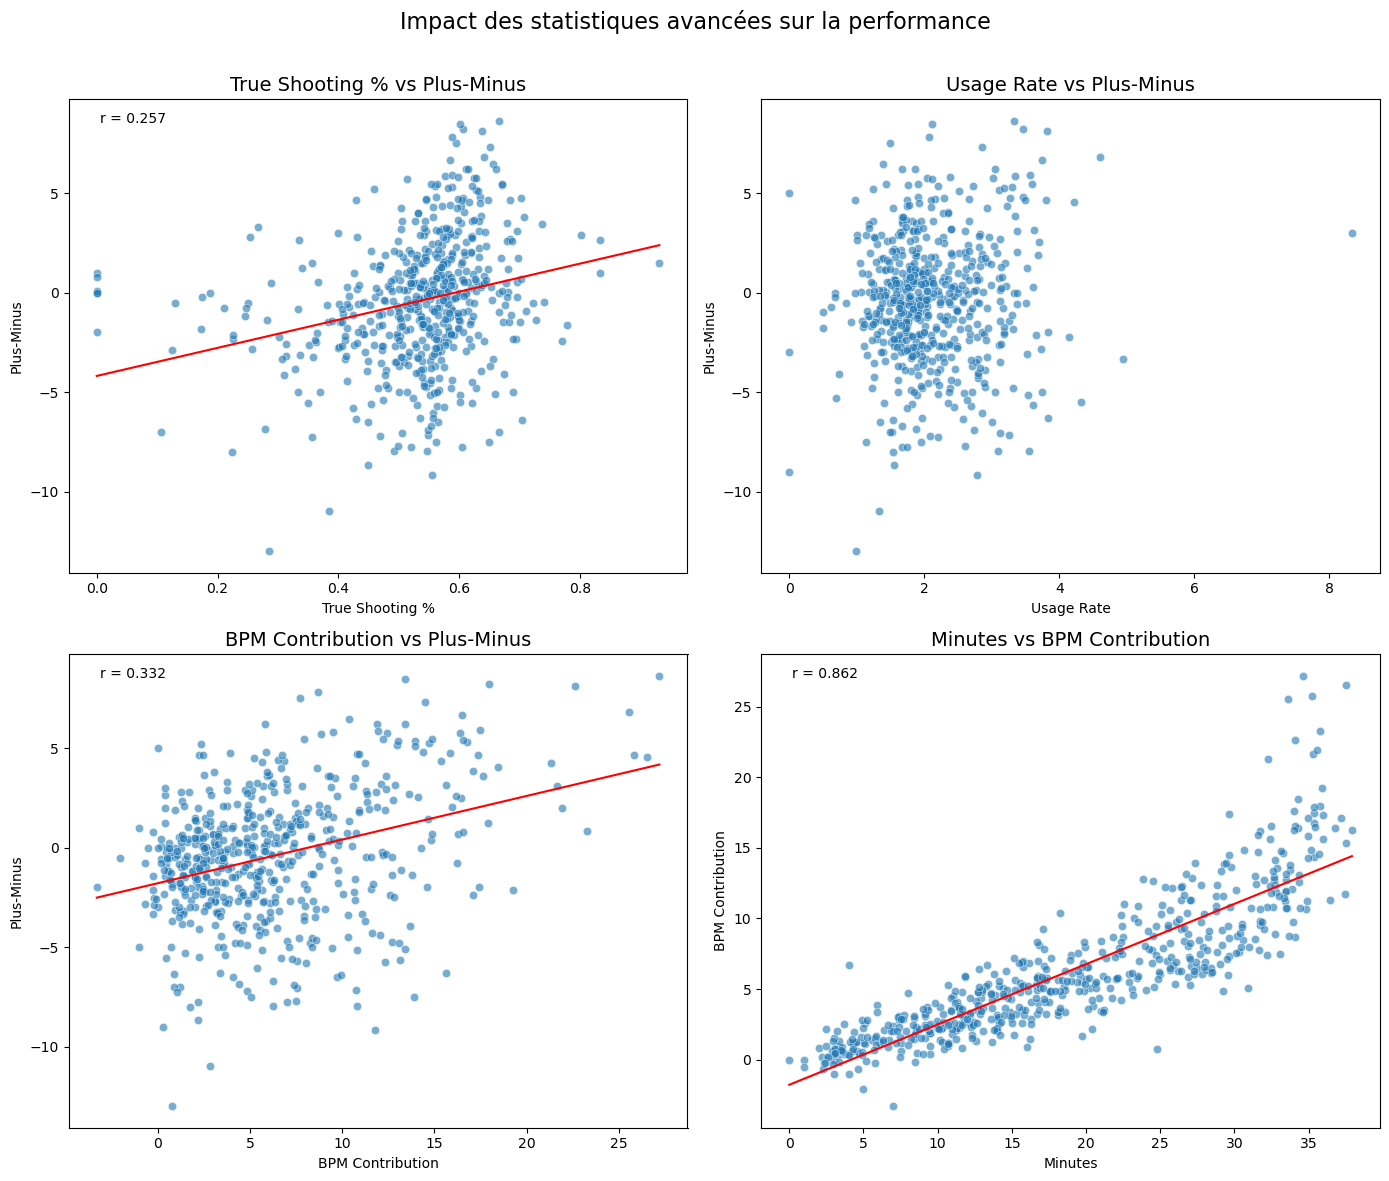

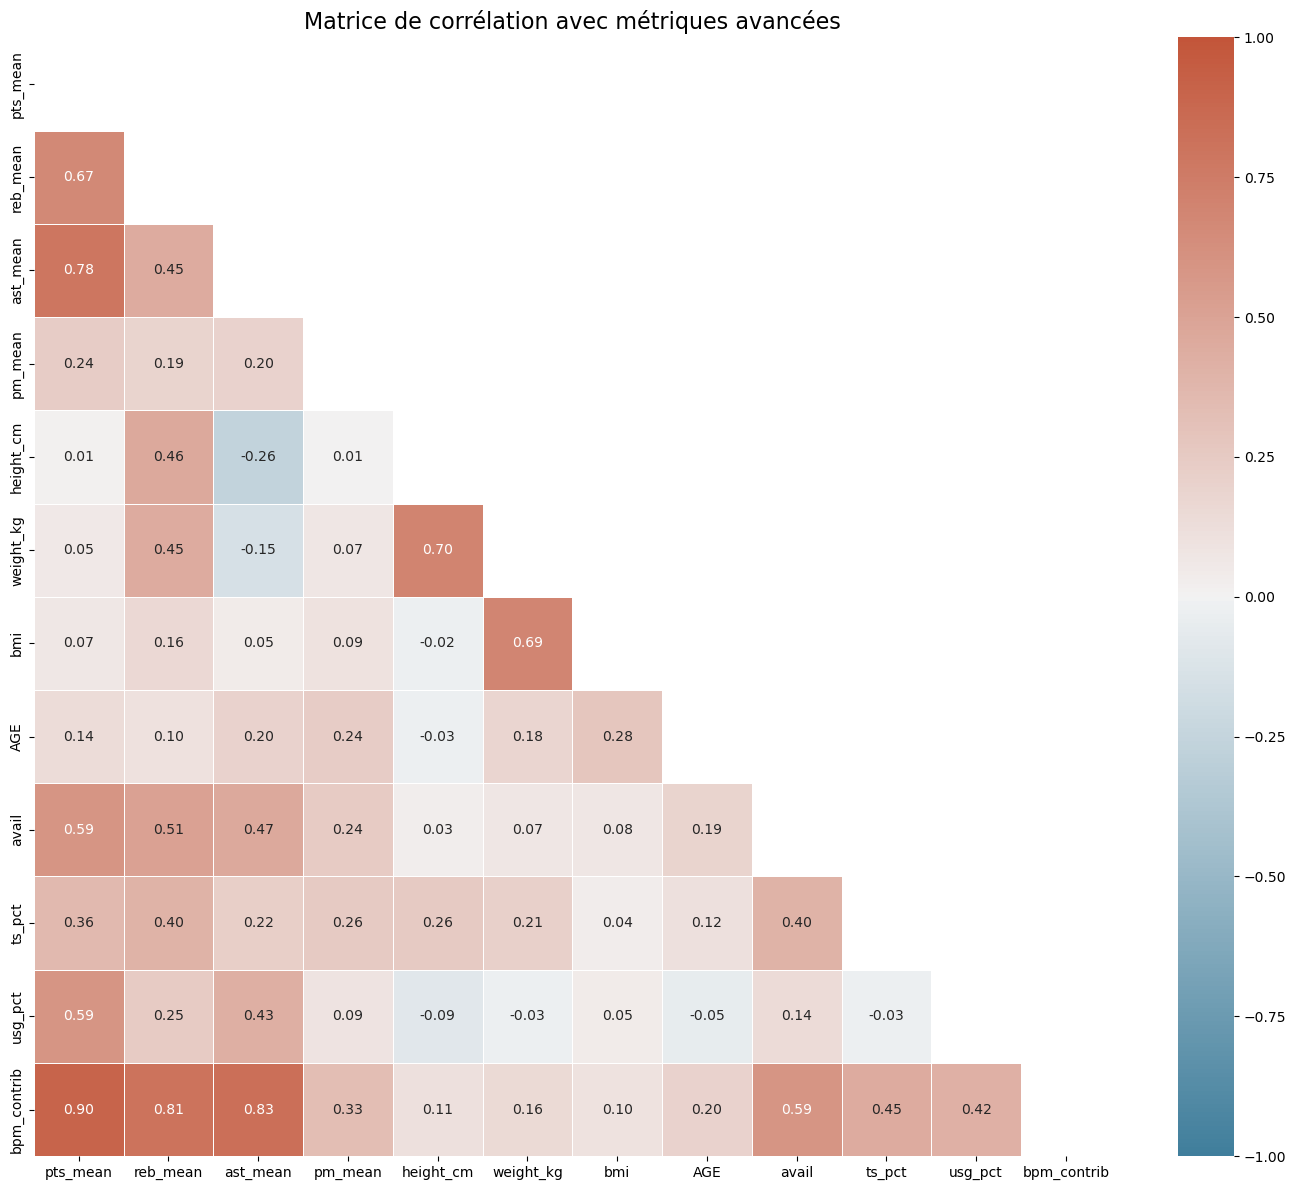

In [27]:

# Create advanced metrics
# Create a new dataframe with advanced stats to complement existing ones
advanced_stats = gamelog.copy()

# Calculate True Shooting Percentage (TS%)
advanced_stats['TS_PCT'] = advanced_stats['PTS'] / (2 * (advanced_stats['FGA'] + 0.44 * advanced_stats['FTA']))

# Calculate Usage Rate (approximate formula)
advanced_stats['USG_PCT'] = ((advanced_stats['FGA'] + 0.44 * advanced_stats['FTA'] + advanced_stats['TOV']) / 
                             (advanced_stats['MIN'] / 5))

# Calculate simple box plus-minus contribution
advanced_stats['BPM_CONTRIB'] = (advanced_stats['PTS'] - advanced_stats['FGA']) + \
                                (advanced_stats['REB'] * 0.7) + \
                                (advanced_stats['AST'] * 1.3) + \
                                (advanced_stats['STL'] * 1.7) + \
                                (advanced_stats['BLK'] * 1.0) - \
                                (advanced_stats['TOV'] * 1.2) - \
                                (advanced_stats['PF'] * 0.5)

# Aggregate by player
adv_per_player = (advanced_stats
                  .groupby('PLAYER_ID')
                  .agg(ts_pct=('TS_PCT', 'mean'),
                       usg_pct=('USG_PCT', 'mean'),
                       bpm_contrib=('BPM_CONTRIB', 'mean'))
                  .reset_index())

# Merge with our existing player dataframe
df_adv = df.merge(adv_per_player, on='PLAYER_ID', how='left')

# Visualize the relationship between these advanced stats and player performance

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 1. True Shooting % vs Plus-Minus
sns.scatterplot(data=df_adv, x='ts_pct', y='pm_mean', ax=axes[0, 0], alpha=0.6)
axes[0, 0].set_title('True Shooting % vs Plus-Minus', fontsize=14)
axes[0, 0].set_xlabel('True Shooting %')
axes[0, 0].set_ylabel('Plus-Minus')

# Add trend line
mask = ~(df_adv['ts_pct'].isna() | df_adv['pm_mean'].isna())
if mask.any():
    try:
        m, b = np.polyfit(df_adv.loc[mask, 'ts_pct'], df_adv.loc[mask, 'pm_mean'], 1)
        x_range = np.linspace(df_adv.loc[mask, 'ts_pct'].min(), df_adv.loc[mask, 'ts_pct'].max(), 100)
        axes[0, 0].plot(x_range, m * x_range + b, color='red')
        r = np.corrcoef(df_adv.loc[mask, 'ts_pct'], df_adv.loc[mask, 'pm_mean'])[0, 1]
        axes[0, 0].text(0.05, 0.95, f'r = {r:.3f}', transform=axes[0, 0].transAxes)
    except np.linalg.LinAlgError:
        print("SVD did not converge for ts_pct vs pm_mean")

# 2. Usage Rate vs Plus-Minus
sns.scatterplot(data=df_adv, x='usg_pct', y='pm_mean', ax=axes[0, 1], alpha=0.6)
axes[0, 1].set_title('Usage Rate vs Plus-Minus', fontsize=14)
axes[0, 1].set_xlabel('Usage Rate')
axes[0, 1].set_ylabel('Plus-Minus')
# Add trend line
mask = ~(df_adv['usg_pct'].isna() | df_adv['pm_mean'].isna())
if mask.any():
    try:
        m, b = np.polyfit(df_adv.loc[mask, 'usg_pct'], df_adv.loc[mask, 'pm_mean'], 1)
        x_range = np.linspace(df_adv.loc[mask, 'usg_pct'].min(), df_adv.loc[mask, 'usg_pct'].max(), 100)
        axes[0, 1].plot(x_range, m * x_range + b, color='red')
        r = np.corrcoef(df_adv.loc[mask, 'usg_pct'], df_adv.loc[mask, 'pm_mean'])[0, 1]
        axes[0, 1].text(0.05, 0.95, f'r = {r:.3f}', transform=axes[0, 1].transAxes)
    except np.linalg.LinAlgError:
        print("SVD did not converge for usg_pct vs pm_mean")

# 3. BPM Contribution vs Plus-Minus
sns.scatterplot(data=df_adv, x='bpm_contrib', y='pm_mean', ax=axes[1, 0], alpha=0.6)
axes[1, 0].set_title('BPM Contribution vs Plus-Minus', fontsize=14)
axes[1, 0].set_xlabel('BPM Contribution')
axes[1, 0].set_ylabel('Plus-Minus')
# Add trend line
mask = ~(df_adv['bpm_contrib'].isna() | df_adv['pm_mean'].isna())
if mask.any():
    try:
        m, b = np.polyfit(df_adv.loc[mask, 'bpm_contrib'], df_adv.loc[mask, 'pm_mean'], 1)
        x_range = np.linspace(df_adv.loc[mask, 'bpm_contrib'].min(), df_adv.loc[mask, 'bpm_contrib'].max(), 100)
        axes[1, 0].plot(x_range, m * x_range + b, color='red')
        r = np.corrcoef(df_adv.loc[mask, 'bpm_contrib'], df_adv.loc[mask, 'pm_mean'])[0, 1]
        axes[1, 0].text(0.05, 0.95, f'r = {r:.3f}', transform=axes[1, 0].transAxes)
    except np.linalg.LinAlgError:
        print("SVD did not converge for bpm_contrib vs pm_mean")

# 4. Minutes vs BPM Contribution (Note: df_adv doesn't have 'MIN' directly, but we have it in df)
# Correctly merge with df to get the 'MIN' column
temp_df = df_adv[['PLAYER_ID', 'bpm_contrib']].merge(df[['PLAYER_ID', 'pts_mean', 'gp']], on='PLAYER_ID', how='left')
# We need to get the Minutes information from the gamelog dataframe
player_minutes = gamelog.groupby('PLAYER_ID')['MIN'].mean().reset_index()
temp_df = temp_df.merge(player_minutes, on='PLAYER_ID', how='left')

sns.scatterplot(data=temp_df, x='MIN', y='bpm_contrib', ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title('Minutes vs BPM Contribution', fontsize=14)
axes[1, 1].set_xlabel('Minutes')
axes[1, 1].set_ylabel('BPM Contribution')
# Add trend line
mask = ~(temp_df['MIN'].isna() | temp_df['bpm_contrib'].isna())
if mask.any():
    try:
        m, b = np.polyfit(temp_df.loc[mask, 'MIN'], temp_df.loc[mask, 'bpm_contrib'], 1)
        x_range = np.linspace(temp_df.loc[mask, 'MIN'].min(), temp_df.loc[mask, 'MIN'].max(), 100)
        axes[1, 1].plot(x_range, m * x_range + b, color='red')
        r = np.corrcoef(temp_df.loc[mask, 'MIN'], temp_df.loc[mask, 'bpm_contrib'])[0, 1]
        axes[1, 1].text(0.05, 0.95, f'r = {r:.3f}', transform=axes[1, 1].transAxes)
    except np.linalg.LinAlgError:
        print("SVD did not converge for MIN vs bpm_contrib")

plt.suptitle('Impact des statistiques avancées sur la performance', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Define the numerical columns from df_adv to use in correlation analysis
num_cols = [col for col in df_adv.columns if df_adv[col].dtype in ['float64', 'int64'] and col not in ['PLAYER_ID', 'gp']]

# Create a correlation matrix with all variables including new ones
# Filter to only include numeric columns and our new advanced metrics
new_num_cols = [col for col in num_cols if col not in ['ts_pct', 'usg_pct', 'bpm_contrib']] + ['ts_pct', 'usg_pct', 'bpm_contrib']
new_corr = df_adv[new_num_cols].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(new_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(new_corr, mask=mask, cmap=cmap, annot=True, fmt='.2f', 
            center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matrice de corrélation avec métriques avancées', fontsize=16)
plt.tight_layout()
plt.show()

In [29]:
# Tests d'ablation : supprimer chaque variable et mesurer l'impact sur la note finale
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# Ajouter la colonne min_mean à df_adv depuis le DataFrame avec MIN
player_minutes = gamelog.groupby('PLAYER_ID')['MIN'].mean().reset_index()
df_adv = df_adv.merge(player_minutes, on='PLAYER_ID', how='left')
df_adv['min_mean'] = df_adv['MIN']  # Renommer pour cohérence

# Sélectionner les principales variables à utiliser pour la notation
to_z = ['pts_mean', 'reb_mean', 'ast_mean', 'pm_mean', 'min_mean', 'ts_pct', 'bpm_contrib']

# Standardiser les variables (Z-score)
scaler = StandardScaler()
df_z = pd.DataFrame(
    scaler.fit_transform(df_adv[to_z].fillna(df_adv[to_z].mean())),
    columns=to_z,
    index=df_adv.index
)

# Calculer la note originale (combinaison linéaire simple)
weights = {
    'pts_mean': 0.25,
    'reb_mean': 0.15, 
    'ast_mean': 0.15,
    'pm_mean': 0.20,
    'min_mean': 0.10,
    'ts_pct': 0.10,
    'bpm_contrib': 0.05
}

# Calculer la note originale
df_adv['note'] = sum(df_z[var] * weight for var, weight in weights.items())

# Pour chaque variable dans to_z, calculer la note sans cette variable
results = []
for var_to_remove in to_z:
    # Recalculer les poids en redistribuant le poids de la variable supprimée
    remaining_vars = [v for v in to_z if v != var_to_remove]
    removed_weight = weights[var_to_remove]
    
    # Redistribuer proportionnellement le poids aux variables restantes
    remaining_weights = {v: weights[v] for v in remaining_vars}
    weight_sum = sum(remaining_weights.values())
    
    # Ajuster les poids pour qu'ils somment à 1
    adjusted_weights = {v: (w/weight_sum) for v, w in remaining_weights.items()}
    
    # Calculer la nouvelle note sans cette variable
    df_adv['new_note'] = sum(df_z[var] * adjusted_weights.get(var, 0) for var in remaining_vars)
    
    # Calculer la corrélation entre la note originale et la nouvelle
    valid_mask = ~(df_adv['note'].isna() | df_adv['new_note'].isna())
    if valid_mask.sum() > 1:  # Besoin d'au moins 2 points valides pour la corrélation
        corr, _ = pearsonr(df_adv.loc[valid_mask, 'note'], df_adv.loc[valid_mask, 'new_note'])
        results.append((var_to_remove, corr))

# Afficher les résultats triés par impact (faible corrélation = variable importante)
results_df = pd.DataFrame(results, columns=["Variable omise", "Corrélation avec note originale"])
results_df['Importance relative'] = 1 - results_df['Corrélation avec note originale']
results_df.sort_values("Corrélation avec note originale")

,Variable omise,Corrélation avec note originale,Importance relative
3,pm_mean,0.966350,0.033650
0,pts_mean,0.981653,0.018347
1,reb_mean,0.988653,0.011347
2,ast_mean,0.989522,0.010478
5,ts_pct,0.992612,0.007388
4,min_mean,0.997319,0.002681
6,bpm_contrib,0.999794,0.000206


/var/folders/_f/2srlysd96rvbypcnm9b8564w0000gn/T/ipykernel_9482/323757840.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette="viridis")


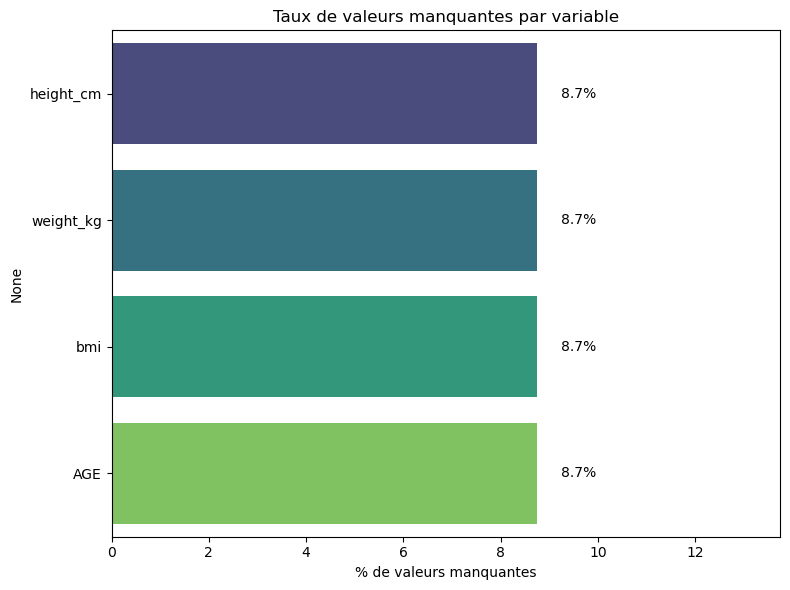

In [30]:
# Calcul des pourcentages de NaN
missing = (df.isna().mean() * 100).loc[lambda x: x > 0]  # ne garder que >0%
missing = missing.sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=missing.values, y=missing.index, palette="viridis")

# Annotations
for i, v in enumerate(missing.values):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

# Titres et labels
plt.xlabel("% de valeurs manquantes")
plt.title("Taux de valeurs manquantes par variable")
plt.xlim(0, missing.max() + 5)  # un peu de marge à droite
plt.tight_layout()
plt.show()

## 10. Conclusion

- Variables pertinentes : `pts_mean`, `reb_mean`, `ast_mean`, `pm_mean`, `avail`, `AGE`, `bmi`.
- Peu de valeurs manquantes sur les stats essentielles.
- Ces variables seront retenues comme features pour l'entraînement du modèle prédictif.